# San Diego Crime Analysis 
### by: Tanya Dilan

In [437]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import folium
import matplotlib.pyplot as plt
import plotly.io as pio
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import dash
from dash import dcc, html
from dash.dependencies import Input, Output


In [439]:
#load data directly from url
SD_data = pd.read_csv("https://seshat.datasd.org/police_nibrs/pd_nibrs_datasd.csv",engine='python')
pd.DataFrame(SD_data)
SD_data.head(20)
SD_data.columns


Index(['objectid', 'nibrs_uniq', 'case_number', 'occured_on', 'approved_on',
       'day_of_week', 'month', 'year', 'code_section', 'group_type',
       'ibr_category', 'crime_against', 'ibr_offense',
       'ibr_offense_description', 'pd_offense_category', 'violent_crime',
       'property_crime', 'beat', 'neighborhood', 'service_area',
       'division_number', 'division', 'block_addr', 'city', 'state', 'zip',
       'query_run_date', 'geocode_status', 'geocode_score', 'latitude',
       'longitude'],
      dtype='object')

In [441]:
#info on the dataframe
SD_data.info(verbose=True, show_counts=True)

#drop irrelevant columns 
df = SD_data.drop(['geocode_status','geocode_score','group_type','beat','query_run_date',
                   'service_area','division_number','nibrs_uniq',
                   'case_number','year','approved_on','code_section','crime_against','ibr_offense',
                  'query_run_date','violent_crime','property_crime','beat','state','division','ibr_category'], axis = 1)
df.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389068 entries, 0 to 389067
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   objectid                 389068 non-null  int64  
 1   nibrs_uniq               389068 non-null  object 
 2   case_number              389068 non-null  object 
 3   occured_on               389068 non-null  object 
 4   approved_on              389062 non-null  object 
 5   day_of_week              389068 non-null  int64  
 6   month                    389068 non-null  int64  
 7   year                     389068 non-null  int64  
 8   code_section             389062 non-null  object 
 9   group_type               389068 non-null  object 
 10  ibr_category             389068 non-null  object 
 11  crime_against            309465 non-null  object 
 12  ibr_offense              389068 non-null  object 
 13  ibr_offense_description  389068 non-null  object 
 14  pd_o

,objectid,occured_on,day_of_week,month,ibr_offense_description,pd_offense_category,neighborhood,block_addr,city,zip,latitude,longitude
0,1,2021-07-11 20:45:00,1,7,All Other Offenses,All Other Offenses,Stockton,100 31st ST,SAN DIEGO,92102.0,32.706474,-117.127455
1,2,2022-02-11 22:00:00,6,2,Theft From Motor Vehicle,Theft From Motor Vehicle,Mira Mesa,10000 MAYA LINDA ROAD,SAN DIEGO,92126.0,32.901073,-117.120120
2,3,2021-05-02 06:00:00,1,5,Simple Assault,Simple Assault,Midway District,3800 Greenwood ST,SAN DIEGO,92110.0,32.754899,-117.206022
3,4,2022-09-21 12:46:21,4,9,Aggravated Assault,Aggravated Assault,Unknown,NaN,Mecca,92254.0,NaN,NaN
4,5,2021-01-09 11:23:00,7,1,Stolen Property Offenses,Stolen Property Offenses,Egger Highlands,1100 Walnut AVE,CHULA VISTA,91911.0,32.605965,-117.088752
5,6,2023-03-04 01:04:00,7,3,Motor Vehicle Theft,Motor Vehicle Theft,Rolando,4500 Mataro DR,SAN DIEGO,92115.0,32.759579,-117.055797
6,7,2020-02-04 11:00:00,3,2,All Other Offenses,All Other Offenses,El Cerrito,5600 University AVE,SAN DIEGO,92105.0,32.747827,-117.075640
7,8,2022-09-13 01:27:00,3,9,Robbery,Robbery,Ocean Beach,Santa Monica AVE & sunset Cliffs BLVD,SAN DIEGO,92107.0,32.745571,-117.246865
8,9,2021-04-12 18:19:00,2,4,Drug/narcotic Violations,Drug/Narcotic Violations,Kearney Mesa,7800 Clairemont Mesa BLVD,SAN DIEGO,92111.0,32.832790,-117.153204
9,10,2022-11-19 12:30:27,7,11,Simple Assault,Simple Assault,East Village,1500 Commercial ST,SAN DIEGO,92113.0,32.705280,-117.150274


In [443]:
#grab unique entries for types or crime
types_of_crime = df['neighborhood'].unique().tolist()
print(types_of_crime)

['Stockton', 'Mira Mesa', 'Midway District', 'Unknown', 'Egger Highlands', 'Rolando', 'El Cerrito', 'Ocean Beach', 'Kearney Mesa', 'East Village', 'Cortez', 'Mission Beach', 'Gaslamp', 'Colina Del Sol', 'South Park', 'San Ysidro', 'Talmadge', 'College West', 'Normal Heights', 'Del Mar Heights', 'Teralta East', 'La Jolla', 'Little Italy', 'Corridor', 'Ocean Crest', 'Skyline', 'Sorrento Valley', 'Bay Park', 'Azalea/Hollywood Park', 'Pacific Beach', 'North Clairemont', 'Birdland', 'North Park', 'Hillcrest', 'North City', 'La Playa', 'Carmel Mountain', 'University City', 'Clairemont Mesa East', 'Barrio Logan', 'Linda Vista', 'Mission Valley East', 'Horton Plaza', 'Marina', 'Ridgeview/Webster', 'Scripps Ranch', 'Serra Mesa', 'Paradise Hills', 'Otay Mesa', 'Mountain View', 'Core-Columbia', 'Lincoln Park', 'Oak Park', 'Carmel Valley', 'Park West', 'Harborview', 'Clairemont Mesa West', 'Otay Mesa West', 'Castle', 'Rancho Bernardo', 'Teralta West', 'Cherokee Point', 'Rancho Penasquitos', 'Grant

In [445]:
#drop na values

df.dropna(subset=['latitude', 'longitude','neighborhood'], inplace=True)
df.head(20)

,objectid,occured_on,day_of_week,month,ibr_offense_description,pd_offense_category,neighborhood,block_addr,city,zip,latitude,longitude
0,1,2021-07-11 20:45:00,1,7,All Other Offenses,All Other Offenses,Stockton,100 31st ST,SAN DIEGO,92102.0,32.706474,-117.127455
1,2,2022-02-11 22:00:00,6,2,Theft From Motor Vehicle,Theft From Motor Vehicle,Mira Mesa,10000 MAYA LINDA ROAD,SAN DIEGO,92126.0,32.901073,-117.120120
2,3,2021-05-02 06:00:00,1,5,Simple Assault,Simple Assault,Midway District,3800 Greenwood ST,SAN DIEGO,92110.0,32.754899,-117.206022
4,5,2021-01-09 11:23:00,7,1,Stolen Property Offenses,Stolen Property Offenses,Egger Highlands,1100 Walnut AVE,CHULA VISTA,91911.0,32.605965,-117.088752
5,6,2023-03-04 01:04:00,7,3,Motor Vehicle Theft,Motor Vehicle Theft,Rolando,4500 Mataro DR,SAN DIEGO,92115.0,32.759579,-117.055797
6,7,2020-02-04 11:00:00,3,2,All Other Offenses,All Other Offenses,El Cerrito,5600 University AVE,SAN DIEGO,92105.0,32.747827,-117.075640
7,8,2022-09-13 01:27:00,3,9,Robbery,Robbery,Ocean Beach,Santa Monica AVE & sunset Cliffs BLVD,SAN DIEGO,92107.0,32.745571,-117.246865
8,9,2021-04-12 18:19:00,2,4,Drug/narcotic Violations,Drug/Narcotic Violations,Kearney Mesa,7800 Clairemont Mesa BLVD,SAN DIEGO,92111.0,32.832790,-117.153204
9,10,2022-11-19 12:30:27,7,11,Simple Assault,Simple Assault,East Village,1500 Commercial ST,SAN DIEGO,92113.0,32.705280,-117.150274
10,11,2022-06-29 20:27:00,4,6,Weapon Law Violations,Weapon Law Violations,Unknown,8300 Verde Ridge RD,CN,91977.0,32.695627,-117.021630


In [447]:
#extract date
new_df['occured_on'] = pd.to_datetime(new_df['occured_on'])
new_df['month'] = new_df['occured_on'].dt.month
new_df['year'] = new_df['occured_on'].dt.year
new_df.head(20)

,occured_on,neighborhood,zip,ibr_offense_description,frequency_ibr,month,year
0,2020-01-01 00:00:01,Carmel Valley,92130.0,Impersonation,1,1,2020
1,2020-01-01 00:00:01,College West,92115.0,Impersonation,1,1,2020
2,2020-01-01 00:00:01,Pacific Beach,92109.0,All Other Larceny,1,1,2020
3,2020-01-01 00:00:30,Core-Columbia,92101.0,Impersonation,1,1,2020
4,2020-01-01 00:01:00,Allied Gardens,92120.0,Impersonation,1,1,2020
5,2020-01-01 00:01:00,Carmel Valley,92130.0,Embezzlement,1,1,2020
6,2020-01-01 00:01:00,East Village,92101.0,Forcible Fondling,1,1,2020
7,2020-01-01 00:01:00,East Village,92101.0,Simple Assault,2,1,2020
8,2020-01-01 00:01:00,Kearney Mesa,92111.0,Embezzlement,1,1,2020
9,2020-01-01 00:01:00,Lincoln Park,92113.0,Burglary/Breaking & Entering,1,1,2020


# Crime frequency in SD dashboard

In [464]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H4('Crime Frequency Comparison by IBR Offense Description'),
    dcc.Dropdown(
        id="year-dropdown",
        options=[{'label': str(year), 'value': year} for year in sorted(new_df['year'].unique())],
        value=new_df['year'].min(),
        placeholder="Select a Year"
    ),
    dcc.Dropdown(
        id="ibr-offense-description-dropdown",
        options=[{'label': cat, 'value': cat} for cat in new_df['ibr_offense_description'].unique()],
        value=new_df['ibr_offense_description'].unique()[0],
        placeholder="Select Crime Type"
    ),
    dcc.Dropdown(
        id="neighborhood1-dropdown",
        options=[{'label': neighborhood, 'value': neighborhood} for neighborhood in new_df['neighborhood'].unique()],
        value=new_df['neighborhood'].unique()[0],
        placeholder="Select a neighborhood"
    ),
    dcc.Dropdown(
        id="neighborhood2-dropdown",
        options=[{'label': neighborhood, 'value': neighborhood} for neighborhood in new_df['neighborhood'].unique()],
        value=new_df['neighborhood'].unique()[1],
        placeholder="Select a second neighborhood"
    ),

    dcc.Graph(id='comparison-graph'),
])
                

@app.callback(
    Output("comparison-graph", "figure"), 
    [Input("year-dropdown", "value"),
     Input("ibr-offense-description-dropdown", "value"),
     Input("neighborhood1-dropdown", "value"),
     Input("neighborhood2-dropdown", "value")]
)

def update_graph(selected_year, selected_ibr_category, neighborhood1, neighborhood2):
    #filter data by user inputs
    filtered_df = new_df[(new_df['year'] == selected_year) &
                            (new_df['ibr_offense_description'] == selected_ibr_category) &
                            (new_df['neighborhood'].isin([neighborhood1,neighborhood2]))]
    #group by month and neighborhood and count crime occurances

    grouped_df = filtered_df.groupby(['month','neighborhood']).size().reset_index(name='crime_count')

    #generate line plot 

    fig = px.line(grouped_df, x="month", y="crime_count", color='neighborhood',
                  title=f"{selected_ibr_category} crime frequency in {neighborhood1} vs. {neighborhood2} in {selected_year}",
                  labels={'crime_count':'Crime Frequency','month':'Month'})


    return fig  # Return the updated figure to be displayed in the graph

# Running the app at the very end
if __name__ == '__main__':
     app.run_server(debug=True)

In [466]:
# # Add frequency count of ibr_categories to new dataframe
# #when doing groupby().size() pandas reverts df back to object, reset the index and name the new column (

# crime_df = new_df.groupby(['year', 'month',
#                      'neighborhood',
#                      'ibr_offense_description'])['ibr_offense_description'].size().reset_index(name= "frequency_ibr") 
# new_df.query('neighborhood != "Unknown"')
# crime_df['ibr_offense_description'].unique()

In [489]:
# #extract date
# new_df['occured_on'] = pd.to_datetime(new_df['occured_on'])
# new_df['month'] = new_df['occured_on'].dt.month

# #filter by neighboorhood

# new_df = new_df[(new_df['neighborhood'].isin(['University Heights','North Park']))]
# new_df.tail(20)



In [471]:
# crime_trends = new_df.groupby(['year','month','ibr_category','neighborhood']).size().reset_index(name='case_count')
# crime_trends['year'].apply(str)
# crime_trends.tail(20)

In [473]:


# df_plot = crime_trends.query("ibr_category=='MOTOR VEHICLE THEFT' and year== 2023")
# fig = px.line(df_plot, x="month", y="case_count", color='neighborhood',title='Car theft in N. Park vs. University Heghts SD in 2023')

# fig.show()

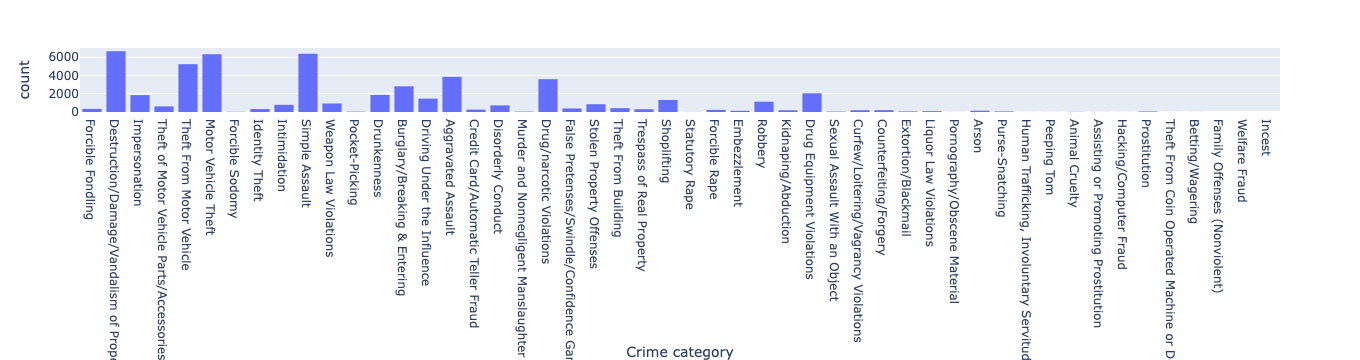

In [487]:
#look at the number of cases in north park in 2023 for the ibr_category

fig = px.histogram(new_df.query("year == 2023 & ~ibr_offense_description.isin(['All Other Larceny','All Other Offenses'])"),
                   x="ibr_offense_description",
                  labels={'count':'Crime Frequency', 'ibr_offense_description': 'Crime category'})
fig.show()

In [491]:
coordinates = [32.7157, -117.1611] # San Diego, California's latitude and longitude
map = folium.Map(location=coordinates, tiles="cartodb positron")
map

In [495]:
# # Add all the individual earthquakes to the map
# def get_radius(freq):
#     if freq < 5:
#         return .5
#     elif freq < 15:
#         return 1
#     elif freq < 50:
#           return 2

# for idx, row in new_df.iterrows():
#     color = '#0a9396' if row['frequency_ibr'] < 4 else '#ee9b00' if row['frequency_ibr'] < 6 else '#ae2012'
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=get_radius(row['frequency_ibr']),
#         color=color,
#         fill=True,
#         fill_color=color,
#         fill_opacity=0.5,
#         weight=1
#     ).add_to(map)

In [497]:
# map